In [106]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()


def random_colour_masks(image):
  """
  random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
  """
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  #img=cv2.imread(coloured_mask)
  
  coloured_mask= cv2.cvtColor(coloured_mask, cv2.COLOR_BGR2GRAY)
  #cv2.imshow("kk",coloured_mask)
  #cv2.waitKey(0)
  #cv2.destroyAllWindows()
  return coloured_mask

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  """
  instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
  """
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  aa=tuple(img.shape)
  
  img = np.zeros(aa, np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 1, 0)
    
    #cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    #cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  
  plt.figure(figsize=(20,30))
  plt.imshow(img,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [74]:
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]

a,b,c=colours[0]

In [75]:
import random

In [76]:
img = Image.open('./person.jpg')
transform = T.Compose([T.ToTensor()])
img = transform(img)
pred = model([img])

In [77]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

(40, 1080, 1920)

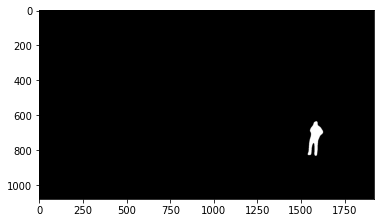

In [78]:
plt.imshow(masks[0], cmap='gray')
plt.show()


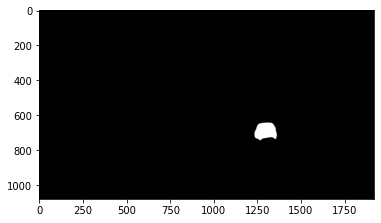

In [79]:


plt.imshow(masks[1], cmap='gray') 
plt.show()



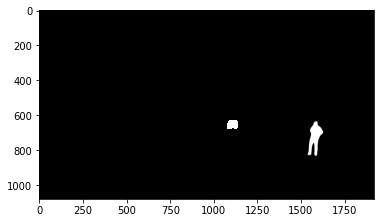

In [80]:


import numpy.ma as ma

combined_masks = ma.masked_array(masks[0],masks[2])
plt.imshow(combined_masks,cmap='gray')
plt.show()



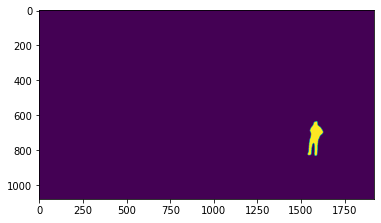

TypeError: data type not understood

In [86]:
mask1 = random_colour_masks(masks[0])

mask2 = random_colour_masks(masks[1])
mask3=random_colour_masks(masks[2])
plt.imshow(mask1); plt.show()

import numpy.ma as ma

combined_masks = ma.masked_array(mask1,mask2)


plt.imshow(combined_masks,cmap='gray')

plt.show()
cv2.imshow("kk1",combined_masks)
cv2.waitKey(0)
cv2.destroyAllWindows()

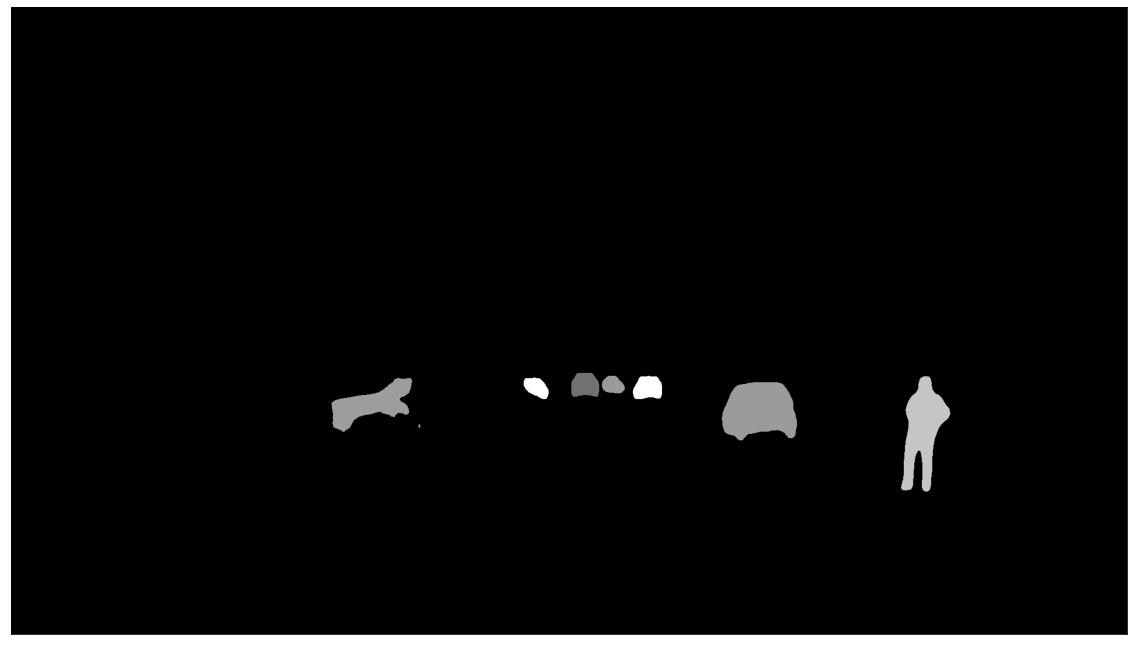

In [108]:


#!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O mrcnn_standing_people.jpg
instance_segmentation_api('./0000001.jpg', 0.75)

